Stochastic Variational Optimization with SVIGP
--

* Mark van der Wilk, 2016 *
* edits by James Hensman, 2016*

In [1]:
%matplotlib inline
import sys
import numpy as np
import numpy.random as rnd
import time
import GPflow
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
M = 50

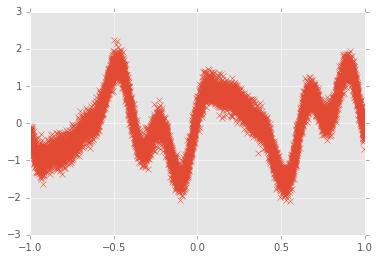

In [3]:
def func(x):
    return np.sin(x * 3*3.14) + 0.3*np.cos(x * 9*3.14) + 0.5 * np.sin(x * 7*3.14)
X = rnd.rand(10000, 1) * 2 - 1
Y = func(X) + rnd.randn(10000, 1) * 0.2
plt.plot(X, Y, 'x')
D = X.shape[1]
Xt = np.linspace(-1.1, 1.1, 100)[:, None]
Yt = func(Xt)

In [4]:
def init():
    kern = GPflow.kernels.RBF(D, 1)
    Z = X[:M, :].copy()
    m = GPflow.svgp.SVGP(X, Y, kern, GPflow.likelihoods.Gaussian(), Z, minibatch_size=len(X))
    return m
m = init()

### Stochastical estimation of ELBO
The minibatch estimate should be an unbiased estimator of the `ground_truth`. Here we show a histogram of the value from different evaluations, together with its mean and the ground truth. The small difference between the mean of the minibatch estimations and the ground truth shows that the minibatch estimator is working as expected.

In [5]:
ground_truth = m.compute_log_likelihood()
m.X.minibatch_size = 100
m.Y.minibatch_size = 100
evals = [m.compute_log_likelihood() for _ in range(100)]

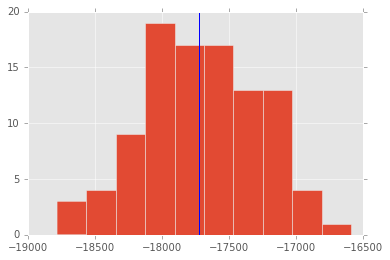

In [6]:
plt.hist(evals)
plt.axvline(ground_truth)

### Minibatches speed up computation
The use of using minibatches is that it decreases the time needed to make an optimisation step, since estmating the objective is cheaper. Here we plot the change in time required with the size of the minibatch. We see that smaller minibatches result in a cheaper estimate of the objective.

In [7]:
mbps = np.logspace(-2, 0, 10)
times = []
objs = []
for mbp in mbps:
    m.X.minibatch_size = m.Y.minibatch_size = int(len(X) * mbp)
    start_time = time.time()
    objs.append([m.compute_log_likelihood() for _ in range(20)])
#    plt.hist(objs, bins = 100)
#    plt.axvline(ground_truth, color='r')
    times.append(time.time() - start_time)

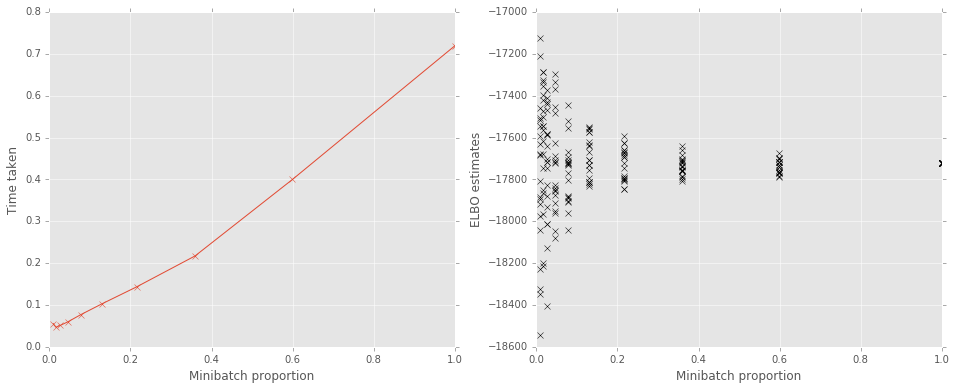

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(mbps, times, 'x-')
ax1.set_xlabel("Minibatch proportion")
ax1.set_ylabel("Time taken")

ax2.plot(mbps, np.array(objs), 'kx')
ax2.set_xlabel("Minibatch proportion")
ax2.set_ylabel("ELBO estimates")



### Running stochastic optimization

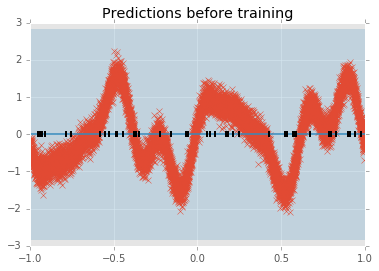

In [9]:
def plot():
    pX = np.linspace(-1, 1, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    plt.plot(X, Y, 'x')
    line, = plt.plot(pX, pY, lw=1.5)
    col = line.get_color()
    plt.fill_between(pX[:,0], pY[:,0]-2*pYv[:,0]**0.5, pY[:,0]+2*pYv[:,0]**0.5, color=col, alpha = 0.2)
    plt.plot(m.Z.value, np.zeros(m.Z.value.shape), 'k|', mew=2)

plot()
plt.title("Predictions before training")


In [10]:
st = time.time()
logt = []
logx = []
logf = []
def logger(x):
    if (logger.i % 10) == 0:
        logx.append(x)
        logf.append(m._objective(x)[0])
        logt.append(time.time() - st)
    logger.i+=1
logger.i = 1

In [11]:
m.X.minibatch_size = 100
m.Y.minibatch_size = 100

m.Z.fixed = True
m.optimize(method=tf.train.AdamOptimizer(), maxiter=5000, callback=logger)

compiling tensorflow function...
done


     fun: -1811.1782307375017
     jac: array([ -9.40902973e+02,  -2.37849571e+03,   2.89828975e+02, ...,
         6.16814434e-02,   8.07405506e-02,  -2.55957584e-02])
 message: 'Finished iterations.'
  status: 'Finished iterations.'
 success: True
       x: array([ 0.62824884, -2.28662567, -3.14612062, ...,  0.05972825,
        0.03040795,  0.37817142])

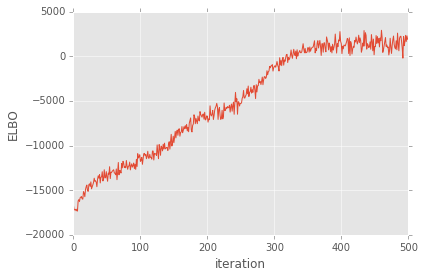

In [12]:
plt.plot(-np.array(logf))
plt.xlabel('iteration')
plt.ylabel('ELBO')

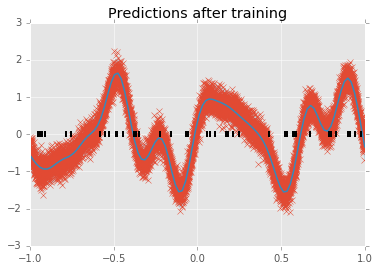

In [13]:
plot()
plt.title("Predictions after training")